# `Generative Adversarial Network` [demo using MNIST]

In [1]:
# importing dependencies
import os
import sys
from datetime import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

### Directories and files

In [2]:
# dataset directory
data_dir = '../datasets/MNIST/'
# Pretrained, tesnorboardv verbose
save_dir = '../saved/playground/mnist-demo'
tensorboard_dir = os.path.join(save_dir, 'tensorboard')
model_dir_g = os.path.join(save_dir, 'model/generator')
model_dir_d = os.path.join(save_dir, 'model/discriminator')

# model files and tensorboard log directory
logdir = os.path.join(tensorboard_dir, 'log')
model_g = os.path.join(model_dir_g, 'model.ckpt')
model_d = os.path.join(model_dir_d, 'model.ckpt')

### Loading dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets(data_dir, one_hot=True)

Extracting ../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [15]:
# inputs
img_size = 28
img_channel = 1
img_shape = (img_size, img_size)  # , img_channel)
img_size_flat = img_size * img_size * img_channel
num_classes = 10

# Network
strides = 2
pool_size = 2
filter_size = 5
conv1_size = 32
conv2_size = 64
fc1_size = 128
fc2_size = 1
dropout_rate = .2

# Training
batch_size = 24
save_step = 100
log_step = 1000
iterations = 10000
learning_rate = 1e-2

### Helpers

In [5]:
# Plot images in grid !!!!!!!!!!! img_size = sqrt(size_flat/channel)!!!!!!!!!!!
def plot_images(imgs, size=28, name=None, smooth=False, **kwargs):
    grid = int(np.sqrt(len(imgs)))
    # Create figure with sub-plots.
    fig, axes = plt.subplots(grid, grid)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        interpolation = 'spline16' if smooth else 'nearest'
        # Plot image.
        ax.imshow(imgs[i].reshape(img_shape), cmap='Greys', interpolation=interpolation, **kwargs)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    if name:
        plt.suptitle(name)
    plt.show()

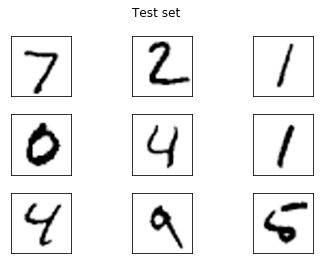

In [6]:
plot_images(data.test.images[:9], name='Test set', smooth=True)

### Discriminator

In [7]:
def discriminator(image, reuse=None, is_training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        net = tf.reshape(image, shape=[-1, img_size, img_size, img_channel])
        # 1st conv layer
        net = tf.layers.conv2d(net, filters=filter_size, kernel_size=conv1_size)
        net = tf.layers.max_pooling2d(net, pool_size=pool_size, strides=strides)
        # 2nd conv layer
        net = tf.layers.conv2d(net, filters=filter_size, kernel_size=conv2_size)
        net = tf.layers.max_pooling2d(net, pool_size=pool_size, strides=strides)
        # flatten
        net = tf.contrib.layers.flatten(net)
        # fully connected
        net = tf.layers.dense(net, units=fc1_size, activation=tf.nn.relu)
        net = tf.layers.dropout(net, rate=dropout_rate, training=is_training)
        # output layer
        output = tf.layers.dense(net, units=fc2_size)
        return output

### Generator

In [ ]:
def generator(noise, reuse=None):
    with tf.variable_scope('generator', reuse=reuse):
        net = tf.layers.dense(noise, units=256, activation=tf.nn.tanh)
        net = tf.contrib.layers.batch_norm(net)
        net = tf.layers.dense(net, units=1024, activation=tf.nn.tanh)
        net = tf.reshape(net, shape=[-1, 8, 8, 16])
        net = tf.contrib.keras.layers.UpSampling2D